# From Simple to Deep CNN with skip connections & batch normalization & dropout (Address Overfitting)

In this worksheet you will apply the various Convolutional Neural Networks (CNNs) architectures to the [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10) data. For this you will be using TensorFlow, and in particular the [Keras](https://keras.io/about/) API, which allows for efficient and intuitive building and training of deep learning models. Essentially, Keras simplifies deep neural network programming by providing modular implementations of layers, activation functions, loss functions (objectives), optimizers, and tools for image and text data.


### Data

The following code loads the CIFAR-10 data set and plots a sample.

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training set size = (50000, 32, 32, 3) 
  Test set size = (10000, 32, 32, 3)


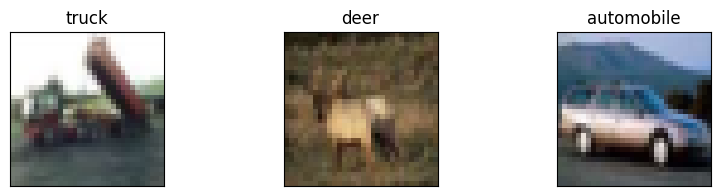

In [1]:
import tensorflow as tf; from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt; import numpy as np

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

print( f"Training set size = {train_images.shape} \n  Test set size = {test_images.shape}" )

# Plot the 3 images from the training set
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 2))
for i in range(2,5):
    plt.subplot(1, 3, i-1); plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(train_images[i]);plt.title(class_names[train_labels[i][0]])
plt.show()

## 1.Simple Convolutional Neural Networks (CNN)

We now implement a basic, shallow CNN with 3 $\times$ Convolution layers (w/ max-pooling), and 2 $\times$ dense layers.

There are two ways to specify models in Keras:

a) the [Sequential model](https://keras.io/guides/sequential_model/) used for networks where each layer has *exactly one input and one output tensor*;

b) the [Functional API](https://keras.io/guides/functional_api/) used for models with non-linear topology, shared layers, and even multiple inputs or outputs (the idea is that a deep learning model can be represented as a directed acyclic graph (DAG) of layers, and the functional API is a way to build such graphs of layers).

Although this model is sequential, we define it using the functional API below for illustration, where:
- `Conv2D` performs spatial (2D) convolutions; you can adjust the # of outputs (`filters`), the window dimensions/filter size (`kernel_size`), the activation function (`activation`), and the padding (`padding = 'same'` uses 0-padding so that the output dimensions are the same as the input. add padding around the input so the output height and width stay the same as the input.)
- `MaxPooling2D` performs max-pooling on the input over some window dimensions (`pool_size`)

You can create a tabular representation of the model with `.summary()` method.

In [2]:
X_input = layers.Input((32,32,3)) # 32x32 RGB image input (3 color channels)
X = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding="same")(X_input) # First convolutional layer
X = layers.MaxPooling2D(pool_size=(2, 2))(X) # Max pooling layer
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.MaxPooling2D((2, 2))(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Flatten()(X) # Flatten the 3D tensor to 1D tensor
X = layers.Dense(64, activation='relu')(X)
X = layers.Dense(10)(X)
X = layers.Softmax()(X)
model = models.Model(inputs=X_input, outputs=X, name="CNN_Model")
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9),
              loss=loss_fn,
              metrics=['accuracy'],)
model.summary()


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Softmax)                    │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 319,178 (1.22 MB)

 Trainable params: 319,178 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

We can now train the model on the training data and measure its (out-of-sample) performance on the test data (`validation_data` argument) with the `.fit()` method. The output contains performance metrics *per epoch* (not batch), which we plot below for signs of over/under-fitting.

In [3]:
N_epochs = 10; N_batch = 128
history_cnn = model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=N_epochs, batch_size=N_batch)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.1727 - loss: 2.2767 - val_accuracy: 0.3012 - val_loss: 2.0185
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2963 - loss: 1.9667 - val_accuracy: 0.3649 - val_loss: 1.8252
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3594 - loss: 1.8055 - val_accuracy: 0.4148 - val_loss: 1.6666
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4132 - loss: 1.6389 - val_accuracy: 0.4521 - val_loss: 1.5345
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4474 - loss: 1.5400 - val_accuracy: 0.4725 - val_loss: 1.4686
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4756 - loss: 1.4755 - val_accuracy: 0.4908 - val_loss: 1.4332
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4928 - loss: 1.4039 - val_accuracy: 0.5171 - val_loss: 1.3518
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5197 - loss: 1.3568 - val_accuracy: 

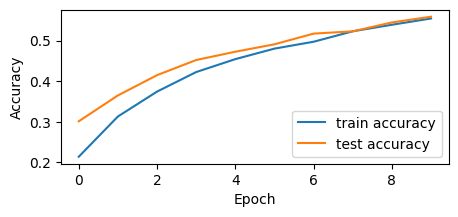

Average test accuracy for CNN model:  0.5587


In [4]:
plt.figure(figsize=(5, 2))
plt.plot(history_cnn.history['accuracy'], label='train accuracy')
plt.plot(history_cnn.history['val_accuracy'], label = 'test accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.show()

print("Average test accuracy for CNN model: ", np.round( history_cnn.history['val_accuracy'][-1], 4) )

## 2.Deep CNN

Even with this basic CNN we get decent (>50%) accuracy, but let's try to improve it using a *deeper* model (i.e., with more layers).

In [5]:
X_input = layers.Input((32,32,3))
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X_input)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.MaxPooling2D((2, 2))(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.MaxPooling2D((2, 2))(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.MaxPooling2D((2, 2))(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.Flatten()(X)
X = layers.Dense(128, activation='relu')(X)
X = layers.Dense(10)(X)
X = layers.Softmax()(X)
model_deep = models.Model(inputs=X_input, outputs=X, name="Deep_CNN_Model")

In [6]:
model_deep.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,weight_decay=0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],)
model_deep.summary()

N_epochs = 10; N_batch = 128
history_deep = model_deep.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=N_epochs, batch_size=N_batch)

Model: "Deep_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,085,802 (4.14 MB)

 Trainable params: 1,085,802 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.1030 - loss: 2.3026 - val_accuracy: 0.1015 - val_loss: 2.3024
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.1119 - loss: 2.3024 - val_accuracy: 0.1477 - val_loss: 2.3023
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.1114 - loss: 2.3022 - val_accuracy: 0.1469 - val_loss: 2.3020
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.1253 - loss: 2.3019 - val_accuracy: 0.1637 - val_loss: 2.3015
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.1296 - loss: 2.3014 - val_accuracy: 0.1510 - val_loss: 2.3005
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.1504 - loss: 2.2999 - val_accuracy: 0.1791 - val_loss: 2.2965
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.1777 - loss: 2.2928 - val_accuracy: 0.1833 - val_loss: 2.2630
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.1824 - loss: 2.2034 - val

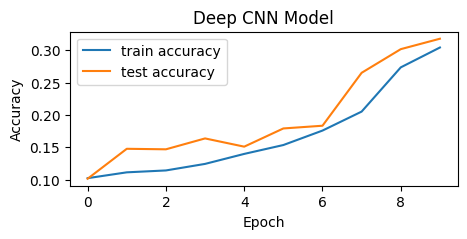

Average test accuracy for Deep CNN model:  0.3176


In [7]:
plt.figure(figsize=(5, 2))
plt.plot(history_deep.history['accuracy'], label='train accuracy')
plt.plot(history_deep.history['val_accuracy'], label = 'test accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Deep CNN Model')
plt.legend(); plt.show()

print("Average test accuracy for Deep CNN model: ", np.round( history_deep.history['val_accuracy'][-1], 4) )

The accuracy seems to have dropped a lot! This indicates problems with training, because the model is at least as expressive as the shallow CNN.

### 2.1. Deep CNN with skip connections

We can try to improve the model by adding *residual/skip* connections. This is implemented by saving the intermediate output as a variable and adding it later on with the `Add()` layer:

In [8]:
X_input = layers.Input((32,32,3))
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X_input)
X_branch1 = X
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.Add()([X, X_branch1])
X = layers.MaxPooling2D((2, 2))(X)

X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X_branch2 = X
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Add()([X, X_branch2])
X = layers.MaxPooling2D((2, 2))(X)

X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X_branch3 = X
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.Add()([X, X_branch3])
X = layers.MaxPooling2D((2, 2))(X)

X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X_branch4 = X
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.Add()([X, X_branch4])


X = layers.Flatten()(X)
X = layers.Dense(128, activation='relu')(X)
X = layers.Dense(10)(X)
X = layers.Softmax()(X)
model_deep_resnet = models.Model(inputs=X_input, outputs=X, name="Deep_CNN_Model_resnet")

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model_deep_resnet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,weight_decay=0),
              loss=loss_fn,metrics=['accuracy'],)
model_deep_resnet.summary()


Model: "Deep_CNN_Model_resnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 32, 32, 32)     │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 32)     │              0 │ conv2d_22[0][0],       │
│                           │                        │                │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 16, 16, 32)     │              0 │ add[0][0]              │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 16, 16, 64)     │              0 │ conv2d_26[0][0],       │
│                           │                        │                │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 8, 8, 64)       │              0 │ add_1[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 8, 8, 64)       │         36,928 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 8, 8, 64)       │         36,928 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 8, 8, 64)       │         36,928 │ conv2d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 8, 8, 64)       │         36,928 │ conv2d_29[0][0]        │
├──────────────────────

 Total params: 1,085,802 (4.14 MB)

 Trainable params: 1,085,802 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
N_epochs = 10; N_batch = 128
history_deep_resnet = model_deep_resnet.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=N_epochs, batch_size=N_batch, )

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.1495 - loss: 2.2664 - val_accuracy: 0.2747 - val_loss: 2.0092
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.2988 - loss: 1.9397 - val_accuracy: 0.3924 - val_loss: 1.7187
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3888 - loss: 1.7011 - val_accuracy: 0.4294 - val_loss: 1.5661
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4366 - loss: 1.5611 - val_accuracy: 0.4738 - val_loss: 1.4752
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.4805 - loss: 1.4580 - val_accuracy: 0.4871 - val_loss: 1.4395
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4952 - loss: 1.4016 - val_accuracy: 0.5092 - val_loss: 1.3870
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5225 - loss: 1.3301 - val_accuracy: 0.5339 - val_loss: 1.2997
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5394 - loss: 1.2832 - 

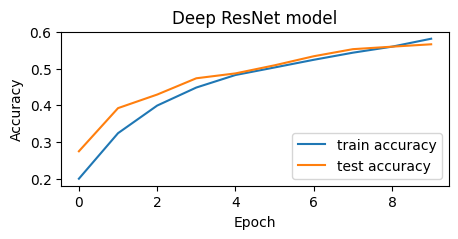

Average test accuracy for Deep ResNet model:  0.5665


In [10]:
plt.figure(figsize=(5, 2))
plt.plot(history_deep_resnet.history['accuracy'], label='train accuracy')
plt.plot(history_deep_resnet.history['val_accuracy'], label = 'test accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Deep ResNet model')
plt.legend(); plt.show()

print("Average test accuracy for Deep ResNet model: ", np.round( history_deep_resnet.history['val_accuracy'][-1], 4) )

The accuracy with skip connections jumped to ~65%, a significant improvement!

### 2.2.Deep CNN with skip connections & batch normalization

Let's see if we can improve even more with *batch normalization*, implemented with `BatchNormalization()`.

batch normalization can: Faster convergence during training; Allows for higher learning rates; Reduces the sensitivity to initialization.


In [11]:
X_input = layers.Input((32,32,3))
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X_input)
X = layers.BatchNormalization()(X)
X_branch1 = X
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch1])
X = layers.MaxPooling2D((2, 2))(X)

X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X_branch2 = X
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch2])
X = layers.MaxPooling2D((2, 2))(X)

X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X_branch3 = X
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch3])
X = layers.MaxPooling2D((2, 2))(X)

X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X_branch4 = X
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch4])


X = layers.Flatten()(X)
X = layers.Dense(128, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dense(10)(X)
X = layers.Softmax()(X)
model_deep_resnet_bn = models.Model(inputs=X_input, outputs=X, name="Deep_CNN_Model_resnet_bn")

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model_deep_resnet_bn.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,weight_decay=0),
              loss=loss_fn, metrics=['accuracy'],)
model_deep_resnet_bn.summary()


Model: "Deep_CNN_Model_resnet_bn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 32, 32, 32)     │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 32)     │            128 │ conv2d_35[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 32)     │            128 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 32)     │            128 │ conv2d_37[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 32)     │            128 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 32, 32, 32)     │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 16, 16, 32)     │              0 │ add_4[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 16, 16, 64)     │            256 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 16, 16, 64)     │            256 │ conv2d_40[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 1,090,922 (4.16 MB)

 Trainable params: 1,088,362 (4.15 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [12]:
N_epochs = 10; N_batch = 128
history_deep_resnet_bn = model_deep_resnet_bn.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=N_epochs, batch_size=N_batch )

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.3101 - loss: 2.0631 - val_accuracy: 0.3710 - val_loss: 1.7969
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.5334 - loss: 1.3017 - val_accuracy: 0.5567 - val_loss: 1.2410
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.6188 - loss: 1.0823 - val_accuracy: 0.5966 - val_loss: 1.1439
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.6709 - loss: 0.9383 - val_accuracy: 0.5887 - val_loss: 1.1661
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7155 - loss: 0.8136 - val_accuracy: 0.6172 - val_loss: 1.1116
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.7639 - loss: 0.6921 - val_accuracy: 0.6418 - val_loss: 1.0400
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.8008 - loss: 0.5949 - val_accuracy: 0.6448 - val_loss: 1.0514
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8343 - loss: 0.4906 - 

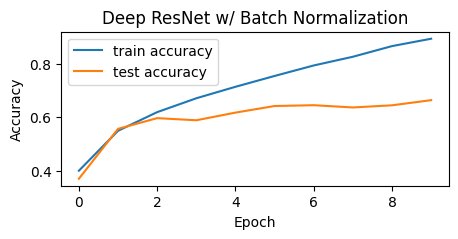

Average test accuracy for Deep ResNet w/ Batch Normalization:  0.6636


In [13]:
plt.figure(figsize=(5, 2))
plt.plot(history_deep_resnet_bn.history['accuracy'], label='train accuracy')
plt.plot(history_deep_resnet_bn.history['val_accuracy'], label = 'test accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Deep ResNet w/ Batch Normalization')
plt.legend(); plt.show()

print("Average test accuracy for Deep ResNet w/ Batch Normalization: ",
      np.round( history_deep_resnet_bn.history['val_accuracy'][-1], 4) )

The training accuracy improved a lot but the test accuracy did not, i.e., it seems like the model is overfitting.

## 2.3.Deep CNN with skip connections & batch normalization & dropout (Address Overfitting)

We will try to address overfitting by randomly dropping a different % of the nodes at certain layers, implemented with `Dropout()`.

In [14]:
import tensorflow as tf; from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt; import numpy as np

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# # Keep only a fraction (frac) of the data ; run ONLY if your computer is slow
# frac = 0.2; train_size = int(len(train_images) * frac); test_size = int(len(test_images) * frac)
# train_images, train_labels = train_images[:train_size], train_labels[:train_size]
# test_images, test_labels = test_images[:test_size], test_labels[:test_size]

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
print( f"Training set size = {train_images.shape} \n  Test set size = {test_images.shape}" )

Training set size = (50000, 32, 32, 3) 
  Test set size = (10000, 32, 32, 3)


In [15]:
X_input = layers.Input((32,32,3))
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X_input)
X = layers.BatchNormalization()(X)
X_branch1 = X
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch1])
X = layers.MaxPooling2D((2, 2))(X)
X = layers.Dropout(0.2)(X)

X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X_branch2 = X
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch2])
X = layers.MaxPooling2D((2, 2))(X)
X = layers.Dropout(0.2)(X)

X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X_branch3 = X
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(64, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch3])
X = layers.MaxPooling2D((2, 2))(X)
X = layers.Dropout(0.3)(X)

X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X_branch4 = X
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(128, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch4])


X = layers.Flatten()(X)
X = layers.Dense(128, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.4)(X)
X = layers.Dense(10)(X)
X = layers.Softmax()(X)

model_deep_resnet_bn_dropout = models.Model(inputs=X_input,
              outputs=X, name="Deep_CNN_Model_resnet_bn_dropout")

model_deep_resnet_bn_dropout.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

model_deep_resnet_bn_dropout.summary()


Model: "Deep_CNN_Model_resnet_bn_dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 32, 32, 32)     │            896 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 32, 32, 32)     │            128 │ conv2d_51[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 32, 32, 32)     │            128 │ conv2d_52[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 32, 32, 32)     │            128 │ conv2d_53[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 32, 32, 32)     │            128 │ conv2d_54[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 32, 32, 32)     │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 16, 16, 32)     │              0 │ add_8[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16, 16, 32)     │              0 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 16, 16, 64)     │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 16, 16, 64)     │            256 │ conv2d_55[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2

 Total params: 1,090,922 (4.16 MB)

 Trainable params: 1,088,362 (4.15 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [16]:
N_epochs = 10; N_batch = 128
history_deep_resnet_bn_dropout = model_deep_resnet_bn_dropout.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=N_epochs, batch_size=N_batch )

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - accuracy: 0.2108 - loss: 2.5945 - val_accuracy: 0.1827 - val_loss: 2.5985
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.3865 - loss: 1.7035 - val_accuracy: 0.4446 - val_loss: 1.5490
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.4453 - loss: 1.5300 - val_accuracy: 0.5028 - val_loss: 1.3722
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.4883 - loss: 1.4122 - val_accuracy: 0.4914 - val_loss: 1.4667
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.5335 - loss: 1.2961 - val_accuracy: 0.5520 - val_loss: 1.2590
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.5654 - loss: 1.2197 - val_accuracy: 0.5670 - val_loss: 1.2043
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.5897 - loss: 1.1548 - val_accuracy: 0.6013 - val_loss: 1.1258
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.6105 - loss: 1.0893 - 

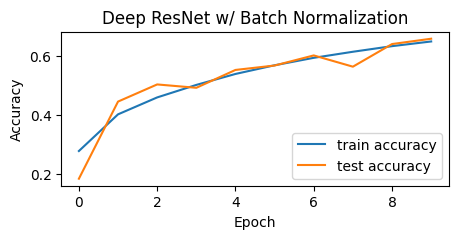

Average test accuracy for Deep ResNet w/ Batch Normalization:  0.658


In [17]:
plt.figure(figsize=(5, 2))
plt.plot(history_deep_resnet_bn_dropout.history['accuracy'], label='train accuracy')
plt.plot(history_deep_resnet_bn_dropout.history['val_accuracy'], label = 'test accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Deep ResNet w/ Batch Normalization')
plt.legend(); plt.show()

print("Average test accuracy for Deep ResNet w/ Batch Normalization: ",
      np.round( history_deep_resnet_bn_dropout.history['val_accuracy'][-1], 4) )

The model is no longer overfitting and the test accuracy has improved as well.

## Example: CNN for Fashion MNIST

Now it is your turn to fit a CNN. You will work on the [Fashion MNIST](https://en.wikipedia.org/wiki/Fashion_MNIST) dataset of fashion images. The dataset contains 60,000 28x28 grayscale images of fashion products from 10 categories. The training set consists of 60,000 images and the test set consists of 10,000 images. The following code loads the data and plots the first 3 training cases.

In [18]:
import tensorflow as tf; from tensorflow import keras;
from tensorflow.keras import layers, models

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add a channel dimension (reshape for CNN input)
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


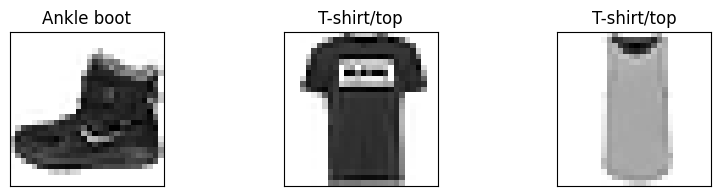

In [19]:
import matplotlib.pyplot as plt

# Class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot the first 3 images
plt.figure(figsize=(10, 2))
for i in range(3):
    plt.subplot(1, 3, i + 1); plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.title(class_names[y_train[i]]); plt.xticks([]); plt.yticks([])
plt.show()

Create and train a CNN on the fashion MNIST data using the techniques presented above (skip connections, batch normalization, dropout, etc) that achieves at least 90% test set accuracy.

In [20]:
# Define the CNN model
X_input = layers.Input((28,28,1))

X = layers.Conv2D(10, (3, 3), activation='relu', padding="same")(X_input)
X = layers.BatchNormalization()(X)
X_branch1 = X
X = layers.Conv2D(10, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(10, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch1])
X = layers.MaxPooling2D((2, 2))(X)
X = layers.Dropout(0.2)(X)

X = layers.Conv2D(10, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X_branch2 = X
X = layers.Conv2D(10, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(10, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Conv2D(10, (3, 3), activation='relu', padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Add()([X, X_branch2])
X = layers.MaxPooling2D((2, 2))(X)
X = layers.Dropout(0.2)(X)

X = layers.Flatten()(X)
X = layers.Dense(128, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.4)(X)
X = layers.Dense(10)(X)
X = layers.Softmax()(X)
model = models.Model(inputs=X_input, outputs=X, name="Fashion_MNIST_CNN_Model")


# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "Fashion_MNIST_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 28, 28, 10)     │            100 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, 28, 28, 10)     │             40 │ conv2d_67[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 28, 28, 10)     │            910 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 28, 28, 10)     │             40 │ conv2d_68[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 28, 28, 10)     │            910 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 28, 28, 10)     │             40 │ conv2d_69[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 28, 28, 10)     │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 14, 14, 10)     │              0 │ add_12[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 14, 14, 10)     │              0 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 14, 14, 10)     │            910 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 14, 14, 10)     │             40 │ conv2d_70[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 14, 14, 10)     │            910 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 14, 14, 10)     │             40 │ conv2d_71[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 14, 14, 10)     │            910 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 70,490 (275.35 KB)

 Trainable params: 70,094 (273.80 KB)

 Non-trainable params: 396 (1.55 KB)

In [21]:
# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6516 - loss: 1.0488 - val_accuracy: 0.7288 - val_loss: 0.8308
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8293 - loss: 0.4657 - val_accuracy: 0.8759 - val_loss: 0.3349
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8580 - loss: 0.3886 - val_accuracy: 0.8830 - val_loss: 0.3213
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8763 - loss: 0.3398 - val_accuracy: 0.8809 - val_loss: 0.3148
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8818 - loss: 0.3206 - val_accuracy: 0.9030 - val_loss: 0.2584
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8899 - loss: 0.3010 - val_accuracy: 0.8996 - val_loss: 0.2644
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8948 - loss: 0.2863 - val_accuracy: 0.9095 - val_loss: 0.2411
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8967 - loss: 0.2775 - val_accuracy: 

313/313 - 2s - 6ms/step - accuracy: 0.9047 - loss: 0.2577
Test accuracy: 0.904699981212616


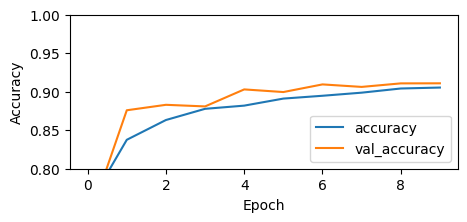

In [22]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# optional plot of training history
plt.figure(figsize=(5, 2))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.ylim([0.8, 1]);
plt.legend(loc='lower right'); plt.show()